# Introduction
Author: Omar Gamel
## Abstract
Analyzing human chromosome 17, we extend the known inversion symmetry between occurence counts of reverse complement k-mers of nucleotides to the GERP score, which is a measure of a nucleotide's conservation across a multispecies alignment. This provides evidence that sequence itself influences how different it will be across species. That is, we have an indication that the genome drives its own evolution.

It is important to emphasize that this is the result of a global analysis across coding regions in Chromosome 17. So one cannot reasonably ascribe the observed differences to the selective advantage of a gene or group of genes. That is, we have an indication that the genome drives its own evolution.

Future work will include generalizing the above to the entire genome, and completing a JAX based deep learning model that predicts GERP score from the sequence. 

## Project Overview

Below we do such an analysis on a Human Chromosome, yielding very interesting discoveries.

Our modus operandi is to collect relevant data in pandas dataframe, then extract insight through various plots and correlations.
We rely on the [GERP score](http://mendel.stanford.edu/SidowLab/downloads/gerp/) to quantify the degree of conservation or variability of a nucleotide. A positive score indicates a nucleotide more conserved than expected under neutral sequence evolution, while a negative score indicates one more variable than expected.

The data is obtained from [ENSEMBL](ensembl.org). We use the softmasked genome, but effectively ignore lower case letters. Check data/paths.py for details.

Many thanks to Dr. Lynn Caporale for important ideas and help creating an overarching [research proposal](https://docs.google.com/document/d/18zZY_aS1gq4SWBPvaKIlqKkqmLpxg_wT0Vn8HHdJSmg). Thanks to the ENSEMBL team for valuable help acquiring the data.



# Setup
We begin by loading the various dependencies and the requisite data. 
Chromosome 17 chosen for initial experiment, because it is of the smaller chromosomes to ease experimentation. Eventually analysis will be extended to entire genome

## Dependencies

In [1]:
from data.load import read_sequence, read_annotation_generator, examine_annotation, read_gerp_scorer
from data.paths import chr17_paths # paths to source data files
from score_collation import score_stats_by_feature_type, score_stats_by_kmer, aggregate_over_position, aggregate_over_frame
from score_analysis import corrcoefs_by_score_count
from visuals import stat_by_kmer_plot

import pandas as pd

In [2]:
# display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

## Load data

In [3]:
# start the analysis with human chromosome 17
paths = chr17_paths

# get the raw sequence dictionary, from a FASTA file
seq_dict = read_sequence(paths.sequence)

# # (optional) examine annotations, from the annotation GFF file
# examine_annotation(paths.annotation)

# get the annotated sequence generator function, from the annotation GFF file
seq_records_gen = read_annotation_generator(paths.annotation, seq_dict=seq_dict)

# get GERP retrieval function, from the BigWig file
gerp_scorer = read_gerp_scorer(paths.gerp)

## Inspect feature annotations
We iterate through the various annotated feature types, measuring the average GERP score for each. This will drive the direction of our analysis going forward.

In [4]:
# check distribution of feature types and their scores.
ft_dfg = score_stats_by_feature_type(seq_records_gen, scorer=gerp_scorer)

INFO:root:Sequence 17 ...
INFO:root:Traversing feature tree ...
INFO:root:Traversed feature tree in 202,358 iterations. Extracted 202,358 features.
INFO:root:Processing feature 0.
INFO:root:Processing feature 25,000.
INFO:root:Processing feature 50,000.
INFO:root:Processing feature 75,000.
INFO:root:Processing feature 100,000.
INFO:root:Processing feature 125,000.
INFO:root:Processing feature 150,000.
INFO:root:Processing feature 175,000.
INFO:root:Processing feature 200,000.
INFO:root:Aggregating statistics


In [5]:
display(ft_dfg)

,seq_name,type,count,mean_len,subfeatures,score_mean,score_std
0,17,exon,88820,239,0,-0.082,6.275
1,17,CDS,51668,142,0,0.650,6.993
2,17,three_prime_UTR,12747,415,0,-0.483,5.574
3,17,five_prime_UTR,9972,120,0,-0.604,5.430
4,17,biological_region,9519,334,0,-0.776,4.835
5,17,mRNA,3203,8527,47461,-0.763,4.022
6,17,lnc_RNA,3013,4691,9928,-0.838,3.842
7,17,ncRNA_gene,893,2594,1169,-0.827,3.398
8,17,transcript,706,5330,2667,-0.787,3.651
9,17,gene,566,8272,3417,-0.778,4.219


We note that **CDS (coding region)** features are second only to exons in number, and are the *only ones with a positive GERP score*, meaning they are, by far, the most conserved type of feature. 
We focus our upcoming analysis on them.

## Aggregation
Here we aggregate the sequence statistics, GERP score broken down by k-mers, frame and position. Explain each column: 

Independent variables
- k: length of the k-mer
- k-mer: a subsequence of adjacent nucleotides of length k
- seq name: i.e. chromosome number
- frame: relative to start position of the feature, ranges from 0 to k-1. one may expect it to be meaningful at least for k=3, where it encodes reading frame
- pos: position index of nucleotide within the k-mer, ranges 0 to k-1

Dependent variables
- count: of each k-mer
- score mean: mean GERP score
- score std: standard deviation of GERP score



In [6]:
# analyze by kmer for CDS (coding sequence) features
kmer_base_df = score_stats_by_kmer(seq_records_gen, gerp_scorer, ['CDS'], k_values=[1,2,3])

INFO:root:Sequence 17 ...
INFO:root:Traversing feature tree ...
INFO:root:Traversed feature tree in 202,358 iterations. Extracted 54,544 features.
INFO:root:Processing feature 0.
INFO:root:Processing feature 25,000.
INFO:root:Processing feature 50,000.
INFO:root:Computed score stats by k-mer, on 644 k-mers, for ['CDS'] feature types.


In [7]:
display(kmer_base_df)

,k,kmer,seq_name,frame,pos,count,score_mean,score_std
0,1,A,17,0,0,1640359,0.699,2.787
1,1,C,17,0,0,2053031,0.641,2.555
2,1,G,17,0,0,2029920,0.641,2.549
3,1,T,17,0,0,1677536,0.714,2.762
4,2,AA,17,0,0,187483,0.928,2.668
...,...,...,...,...,...,...,...,...
639,3,TTT,17,1,1,33772,0.787,2.617
640,3,TTT,17,1,2,33772,0.987,2.628
641,3,TTT,17,2,0,37112,0.696,2.612
642,3,TTT,17,2,1,37112,1.259,2.352


To facilitate subsequent analysis at varying levels of granularity, we create additional dataframes with further aggregation by position, frame, or both. 

In [8]:
# aggregate over position, keeping frame
kmer_frame_df = aggregate_over_position(kmer_base_df)

# aggregate over frame, keeping position
kmer_pos_df = aggregate_over_frame(kmer_base_df)

# aggregate over both frame and position (equivalent to aggregate_over_frame(kmer_frame_df), as aggregatons commute)
kmer_df = aggregate_over_position(kmer_pos_df)


# Investigation
Based on the detailed dataframe above, one can pursue a few lines of investigation to derive insight:
1. **Count and GERP score by k-mer**: What are the differences in counts and GERP scores between different k-mers? Are there any discernible relationships in this regard between related k-mers? What are the implications?
1. Does the **postion** within the k-mer have a consistent effect on GERP score?
1. Does the **frame** have a consistent effect on k-mer count and GERP scores?

We investigate each of the above with the aid of some custom plots, computed correlations, and relevant literature search with citation.

## Count and GERP score by k-mer
We start by observing the most aggregated dataframe.
### Table

In [9]:
display(kmer_df)

,k,kmer,seq_name,count,score_mean,score_std
0,1,A,17,1640359,0.699,2.787
1,1,C,17,2053031,0.641,2.555
2,1,G,17,2029920,0.641,2.549
3,1,T,17,1677536,0.714,2.762
4,2,AA,17,376385,0.853,1.335
5,2,AC,17,363379,0.581,1.354
6,2,AG,17,561446,0.708,1.274
7,2,AT,17,337984,0.584,1.445
8,2,CA,17,584331,0.593,1.374
9,2,CC,17,603592,0.622,1.274


We examine the table above, making some observations for each k

**Mononucleotides: k=1**

GERP scores somewhat different by nucleotide, small difference but statistically significant at this count.
To see this. Standard deviation is raw - to get standard error of the mean divide by sqrt of count, very small number.

We notice A-T counts are the same, ass are C-G counts. It turns out this is [Chargaff's second rule](https://en.wikipedia.org/wiki/Chargaff%27s_rules).
Intriguingly, we notice the same for GERP score. 
Does this generalize to higher k?

**Dinucleotides: k=2**

We notice the palindrome CG is the only dinuleotide with a negative GERP score, substantially lower than all others. This is likely an effect of [CG methylation and subsequent mutation](https://academic.oup.com/nar/article/35/20/6798/2400018?login=false). This may also explain why CG has the second lowest counts. Interestingly, even though TA, another palindrome, has the lowest counts, it's GERP score is more in line with other dinucleotides. 

Looking at counts, counts of CC and GG about the same. As are AA and TT. This may lead one to posit complement, however, doesn't work, e.g. AC and TG complements but with very different counts.
Looking more carefully, it turns out the correspondence holds for the reverse complement. e.g. AC and GT, CA and TG. 

What we newly discover here is that the same holds for the GERP score. It too is about the same between a k-mer and its reverse complement

**Trinucleotides (codons): k=3**

Surely this pattern can't continue to hold for k=3. Trinucleotides, i.e. codons, within coding regions are the essential building blocks of the genetic code, where each encodes for an amino acid or indicates a stop. One may intuitively think the symmetries that hold for lower k would unnecessarily constrain protein coding for k=3.

Nevertheless, it turns out this fascinating generalization to Chargaff's second rule, known as the [Inversion symmetry](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC309655/), continues to hold. It is even known to hold across the genome of humans and many species. How can that be? Why is true? Nobody knows for certain.

We again find that this also holds for the GERP score.

In a thorough literature search, we were unable to find that this Inversion symmetry for GERP score, or indeed any measure of sequence conservation, was reported in the literature. Just like the inversion symmetry for the k-mer counts, we have yet to find satisfying explanations for this observation. However one can hypothesize that the processes that determine both the k-mer count and the its conservation physically involve an agent that seeks affects sequences on either DNA strand equally.

### Correlations
We quantify the above observations yielded by inspection with some correlations

In [10]:
corrcoefs_by_score_count(kmer_df, k_values=[2,3])

k = 2, correlation between k-mer count and score 0.383
k = 2, pairwise reverse complement correlation between k-mer counts 0.995
k = 2, pairwise reverse complement correlation between k-mer scores 0.991
k = 3, correlation between k-mer count and score 0.502
k = 3, pairwise reverse complement correlation between k-mer counts 0.996
k = 3, pairwise reverse complement correlation between k-mer scores 0.996


Correlations confirm our observations. For k=2 and k=3, both k-mer counts and GERP scores are perfectly correlated between each k-mer and its reverse complement.

Note that the k-mer counts and the GERP score are only weakly correlated with one another. This indicates that the GERP score is not simply dependent on k-mer count, and that the GERP score inversion symmetry we discovered is not just a simple consequence of generalized Chargaff's second rule.

### Plots
Finally, we verify this visually with plots, with palindromes on the left, and placing pairs of reverse complements adjacently.
Note that palindromes only exist for even k.

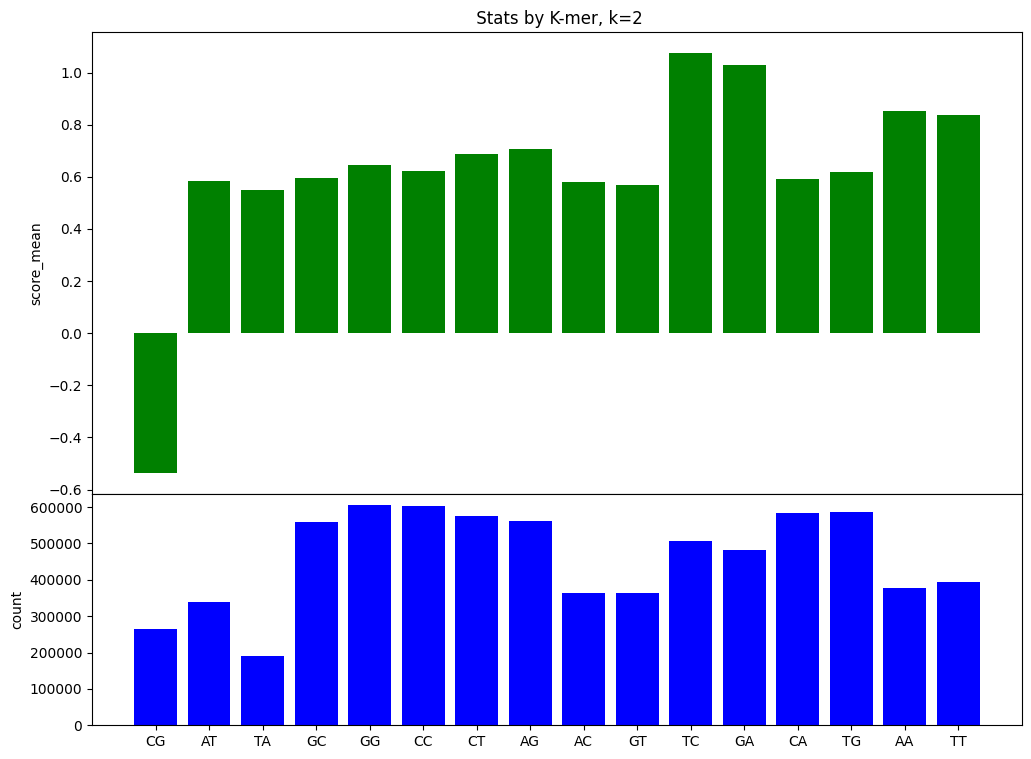

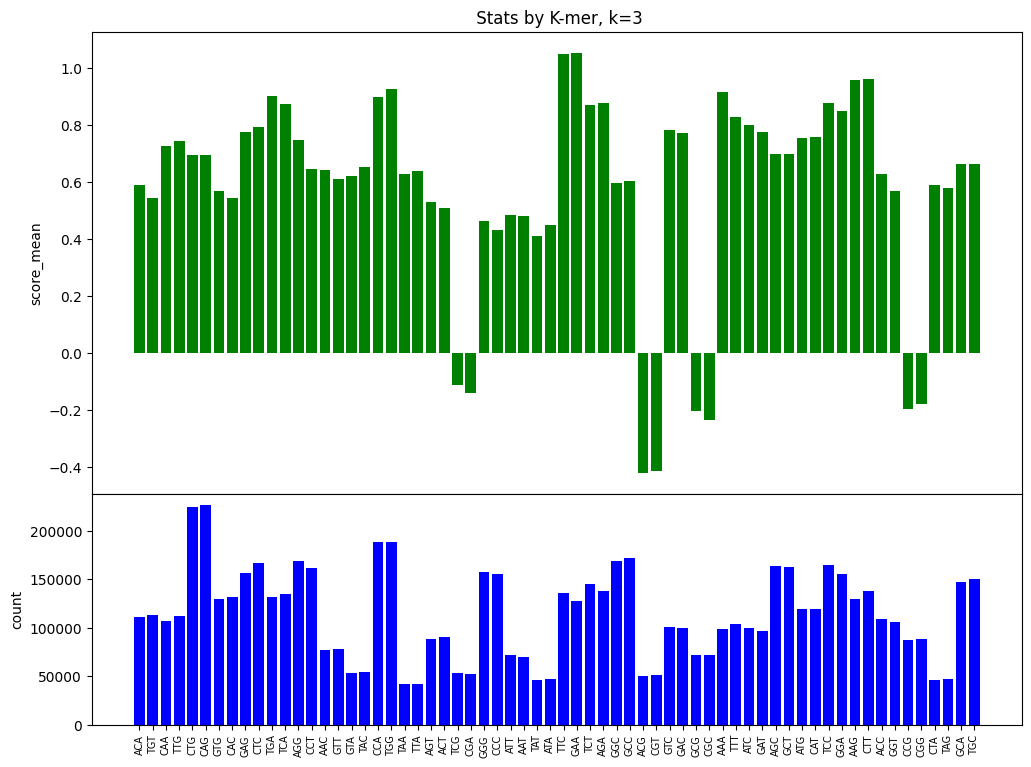

In [11]:
stat_by_kmer_plot(kmer_df, k_values=[2,3])

One can see the two inversion symmetries visualized by pairs of adjacent reverse complement codons having roughly the same counts and GERP scores.
Note that for k=2, the four left-most dinucleotides are palindromes, and thus their own reverse complements.

## Effect of **position** with k-mer on GERP Score
### Table
Splitting up the GERP score by position within each k-mer, we wish to see if the observed pattern above continues on per-nucleotide level. 

In [12]:
display(kmer_pos_df)

,k,kmer,seq_name,pos,count,score_mean,score_std
0,1,A,17,0,1640359,0.699,2.787
1,1,C,17,0,2053031,0.641,2.555
2,1,G,17,0,2029920,0.641,2.549
3,1,T,17,0,1677536,0.714,2.762
4,2,AA,17,0,376385,0.912,1.900
...,...,...,...,...,...,...,...
223,3,TTG,17,1,112448,0.578,1.698
224,3,TTG,17,2,112448,1.016,1.341
225,3,TTT,17,0,103775,0.731,1.494
226,3,TTT,17,1,103775,0.971,1.448


We first notice there are, in general, significant differences between GERP scores of different positions within the same k-mer. E.g. in TG, the T has average GERP score of 0.375 while the G is much more conserved at 0.890.

### Correlations
After splitting up the scores by position within a k-mer, we again measure the correlations between scores between reverse complements for *inverted* positions. That is, the correlation between the score of *first* nucleotide in a k-mer and the score of the *last* nucleotide in its reverse complements.

In [13]:
corrcoefs_by_score_count(kmer_pos_df, k_values=[2, 3])

k = 2, correlation between k-mer count and score 0.360
k = 2, pairwise reverse complement correlation between k-mer counts 0.995
k = 2, pairwise reverse complement correlation between k-mer scores 0.991
k = 3, correlation between k-mer count and score 0.372
k = 3, pairwise reverse complement correlation between k-mer counts 0.996
k = 3, pairwise reverse complement correlation between k-mer scores 0.992


The pairwise correlations are just as high as before when position is considered. This further details out conclusion, that GERP score is the same between reverse complement codons, even on a **nucleotide by nucleotide basis**.

In [195]:
# TODO: compute some measure to find if there is a consistent difference between GERP across positions. 
# Aggregated across all k-mers there cannot be a difference, since each nucleotide is counted once in each position, depending on the k-mer window.
# But can we group k-mers depending on which position is more conserved? Is this a meaningful grouping?

### Plots
We plot the results again, but broken down by position within each k-mer.

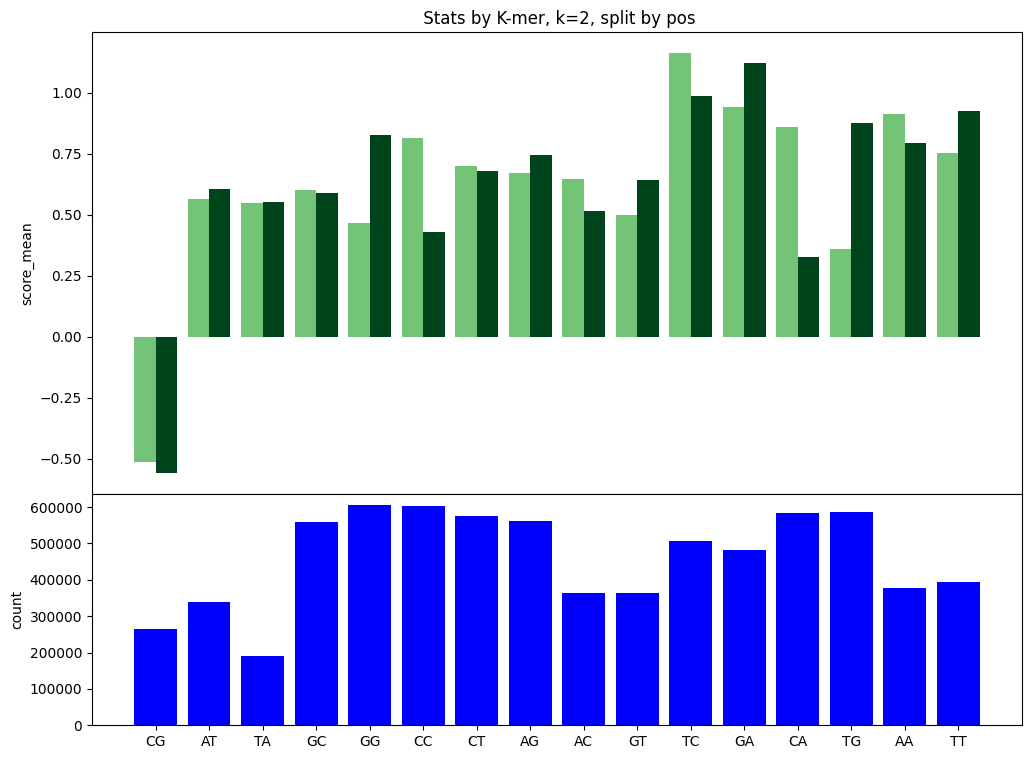

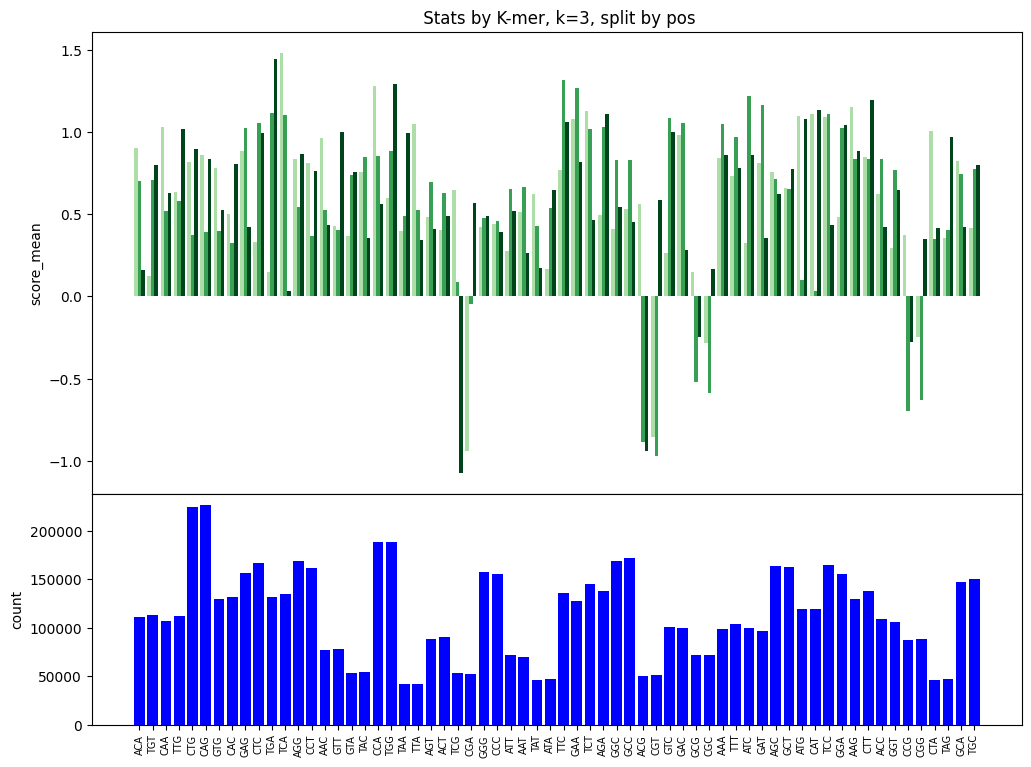

In [14]:
stat_by_kmer_plot(kmer_pos_df, splitby_col='pos', k_values=[2,3])

We note the relation still holds even on the level of position. One can see that for each position in a k-mer, the GERP score is about the same as the opposite position in the reverse complement. 
Palindromic dinucleotides have the same GERP score for both positions, as expected. We also note that CC/GG and CA/TG have very different GERP scores between their two positions, a fact which was obscured by averaging.

We see (k=3) codons containing CG have the CG positions with negative or low GERP score, while the third position has a much higher GERP score.

## Effect of **frame** on k-mer count and GERP Score

In [15]:
display(kmer_frame_df)

,k,kmer,seq_name,frame,count,score_mean,score_std
0,1,A,17,0,1640359,0.699,2.787
1,1,C,17,0,2053031,0.641,2.555
2,1,G,17,0,2029920,0.641,2.549
3,1,T,17,0,1677536,0.714,2.762
4,2,AA,17,0,187483,0.856,1.887
...,...,...,...,...,...,...,...
223,3,TTG,17,1,31284,0.597,1.573
224,3,TTG,17,2,34266,0.664,1.579
225,3,TTT,17,0,32891,0.780,1.507
226,3,TTT,17,1,33772,0.799,1.515


For k=2, frame does not seem to have much of an effect on counts or GERP scores.
For k=3, there does seem to be an effect for some codons, where count and mean GERP score can vary by up to 50% between frames. But it is not clear to us yet how to generally characterize this effect.

### Correlations
We split up data by frame for correlation calculation.

In [16]:
corrcoefs_by_score_count(kmer_frame_df, k_values=[2, 3])

k = 2, correlation between k-mer count and score 0.384
k = 2, pairwise reverse complement correlation between k-mer counts 0.994
k = 2, pairwise reverse complement correlation between k-mer scores 0.987
k = 3, correlation between k-mer count and score 0.518
k = 3, pairwise reverse complement correlation between k-mer counts 0.917
k = 3, pairwise reverse complement correlation between k-mer scores 0.954


The correlations are still quite high, though mildly subdued when stratified by frame.